# Модель CatBoost

## Импорт необходимых библиотек и модулей

In [4]:
import pandas as pd
import numpy as np
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import train_test_split
import joblib
import json
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier

## Загружаем предобработанные данные, смотрим распределение классов.
* Target в данных составляет всего 3%, что говорит о сильном дисбалансе классов. Учитываем это в дальнейшем (class_weight='balanced', stratify=y).
* Загружаем только 300_000 случайных строк для грида.

In [2]:
# === ПУТИ ===
DATA_ROOT = '/home/jupyter/project/processed_data_1'
TRAIN_DIR = os.path.join(DATA_ROOT, 'train')

# === ЗАГРУЗКА ===
df_grid = pd.read_parquet(os.path.join(TRAIN_DIR, 'final_train.parquet'))
df_grid = df_grid.sample(n=300_000, random_state=42)
print(f"✅ Загружено {len(df_grid):,} строк")

# === ПРОВЕРИМ РАСПРЕДЕЛЕНИЕ КЛАССОВ ===
print(df_grid['flag'].value_counts(normalize=True))

# === Фичи и таргет ===
y = df_grid['flag'].values
X = df_grid.drop(columns=['flag', 'id'])
print(f"Размер X: {X.shape}, y: {y.shape}")


✅ Загружено 300,000 строк
0    0.964587
1    0.035413
Name: flag, dtype: float64
Размер X: (300000, 428), y: (300000,)


## GRID SEARCH для CatBoostClassifier.
* Гиперпараметры используем loss_function='Logloss' - функция потерь для бинарной классификации, eval_metric='AUC' - метрика оценки модели, bootstrap_type='Bayesian' - стохастический способ, добавляющий шум в веса объектов, повышая устойчивость, auto_class_weight='balanced' - баланс классов, random_state=42 указываем для сходимости.

In [3]:
PARAMS_PATH = os.path.join(DATA_ROOT, 'catboost_best_params.json')
# === PIPELINE ===
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ('clf', CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    bootstrap_type='Bayesian',
    auto_class_weights='Balanced',
    allow_writing_files=False,
    verbose=False,
    random_state=42))
])

# === ПАРАМЕТРЫ ДЛЯ ГРИДА ===
param_grid = {
    'clf__depth': [6, 8], # Глубина деревьев
    'clf__learning_rate': [0.01, 0.05, 0.1], # Темп обучения
    'clf__l2_leaf_reg': [3, 9], # Коэффициент L2-регуляризации
    'clf__iterations': [1000], # Количество деревьев
    'clf__bagging_temperature': [0.5, 1.0] # степень случайности при отборе подмножеств данных
}

# === GRID SEARCH ===
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    n_jobs=-1,
    verbose=2
)
grid.fit(X, y)

print("\n=== РЕЗУЛЬТАТЫ GRIDSEARCH ===")
print("Лучшие параметры:", grid.best_params_)
print(f"ROC-AUC (CV): {grid.best_score_:.5f}")

with open(PARAMS_PATH, 'w') as f:
    json.dump(grid.best_params_, f, indent=4)

print(f"\n✅ Лучшие параметры сохранены в: {PARAMS_PATH}")


Fitting 3 folds for each of 24 candidates, totalling 72 fits

=== РЕЗУЛЬТАТЫ GRIDSEARCH ===
Лучшие параметры: {'clf__bagging_temperature': 1.0, 'clf__depth': 6, 'clf__iterations': 1000, 'clf__l2_leaf_reg': 9, 'clf__learning_rate': 0.05}
ROC-AUC (CV): 0.73820

✅ Лучшие параметры сохранены в: /home/jupyter/project/processed_data_1/catboost_best_params.json


## Получив лучшие параметры на GRID SEARCH применим их на всех данных.
* Для этого создадим функции: 
1. ЗАГРУЗКА ДАННЫХ
2. ЗАГРУЗКА ПАРАМЕТРОВ
3. СОЗДАНИЕ ПАЙПЛАЙНА
4. ОБУЧЕНИЕ МОДЕЛИ
5. ПРЕДСКАЗАНИЕ

In [2]:
# === ГЛОБАЛЬНЫЕ КОНСТАНТЫ ===
DATA_ROOT = '/home/jupyter/project/processed_data_1'
TRAIN_DIR = os.path.join(DATA_ROOT, 'train')
PARAMS_PATH = os.path.join(DATA_ROOT, 'catboost_best_params.json')
MODEL_PATH = os.path.join(DATA_ROOT, 'final_catboost_model.pkl')
TARGET_COL = 'flag'


# === 1. ЗАГРУЗКА ДАННЫХ ===
def load_data(train_path: str = TRAIN_DIR, sample_frac: float = 1.0):
    """Загружает финальный parquet и возвращает X, y"""
    final = pd.read_parquet(os.path.join(train_path, 'final_train.parquet'))
    if sample_frac < 1.0:
        final = final.sample(frac=sample_frac, random_state=42)
    print(f"✅ Загружено {len(final):,} строк, {final.shape[1]} колонок")

    X = final.drop(['id', TARGET_COL], axis=1)
    y = final[TARGET_COL]

    del final
    gc.collect()
    return X, y


# === 2. ЗАГРУЗКА ПАРАМЕТРОВ ===
def load_best_params(params_path: str = PARAMS_PATH):
    """Загружает лучшие параметры CatBoost"""
    if os.path.exists(params_path):
        with open(params_path, 'r') as f:
            best_params = json.load(f)
        best_params = {k.split('__')[-1]: v for k, v in best_params.items()}
        print(f"✅ Загружены лучшие параметры из {params_path}: {best_params}")
    else:
        print("⚠️ Не найден файл с параметрами, используются дефолтные.")
        best_params = {}
    return best_params


# === 3. СОЗДАНИЕ ПАЙПЛАЙНА ===
def build_pipeline(best_params: dict):
    """Создаёт пайплайн с CatBoost"""
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("model", CatBoostClassifier(
            loss_function='Logloss',
            eval_metric='AUC',
            bootstrap_type='Bayesian',
            auto_class_weights='Balanced',
            allow_writing_files=False,
            verbose=False,
            random_state=42,
            **best_params
        ))
    ])
    return pipe


# === 4. ОБУЧЕНИЕ МОДЕЛИ ===
def fit_model(X, y, model_path: str = MODEL_PATH, test_size: float = 0.2):
    """Обучает модель, сохраняет её и тестовые данные"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=1 - test_size, random_state=42, stratify=y, shuffle=True
    )

    best_params = load_best_params()
    pipe = build_pipeline(best_params)

    print("\n🚀 Обучаем финальную CatBoost...")
    pipe.fit(X_train, y_train)
    print("✅ Модель обучена.")

    # === Оценка ===
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"\n📊 ROC-AUC: {roc_auc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))
    print(confusion_matrix(y_test, y_pred))

    # === Сохранение модели ===
    joblib.dump(pipe, model_path)
    print(f"\n💾 Модель сохранена в: {model_path}")

    return pipe



# === 5. ПРЕДСКАЗАНИЕ ===
def predict_model(input_data, model_path: str = MODEL_PATH, plot: bool = True):
    
    pipe = joblib.load(model_path)
    print("✅ Модель загружена.\n")

    # --- Разделение фич и целевой ---
    if "flag" in input_data.columns:
        y_true = input_data["flag"].values
        X = input_data.drop(columns=["flag"])
    else:
        y_true = None
        X = input_data

    # --- Предсказание ---
    y_proba = pipe.predict_proba(X)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    # --- Метрики ---
    if y_true is not None:
        roc_auc = roc_auc_score(y_true, y_proba)
        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, output_dict=True)

        acc = report['accuracy']
        prec0, rec0, f10 = report['0']['precision'], report['0']['recall'], report['0']['f1-score']
        prec1, rec1, f11 = report['1']['precision'], report['1']['recall'], report['1']['f1-score']

        print("📊 **Оценка модели на тесте**")
        print("────────────────────────────")
        print(f"🎯 ROC-AUC:       {roc_auc:>8.4f}")
        print(f"✅ Accuracy:      {acc:>8.4f}")
        print()
        print("Класс | Precision | Recall | F1-score")
        print("───────┼───────────┼────────┼─────────")
        print(f"  0    |  {prec0:>8.4f} | {rec0:>6.4f} | {f10:>7.4f}")
        print(f"  1    |  {prec1:>8.4f} | {rec1:>6.4f} | {f11:>7.4f}")
        print("────────────────────────────")

        # --- Матрица ошибок ---
        if plot:
            plt.figure(figsize=(5, 4))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
            plt.title(f"📉 Confusion Matrix (ROC-AUC = {roc_auc:.3f})")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.show()

            # ROC-кривая
            from sklearn.metrics import roc_curve
            fpr, tpr, _ = roc_curve(y_true, y_proba)
            plt.figure(figsize=(5, 4))
            plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})")
            plt.plot([0, 1], [0, 1], 'k--', label="Random")
            plt.legend()
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("🚀 ROC Curve — LGBM")
            plt.grid(True)
            plt.show()

    # --- Возвращаем DataFrame ---
    result = pd.DataFrame({
        "id": input_data["id"] if "id" in input_data.columns else range(len(y_pred)),
        "pred": y_pred,
        "proba": y_proba
    })

    return result




## Загружаем данные и обучаем модель.

In [5]:
X, y = load_data()
fit_model(X, y)

✅ Загружено 3,000,000 строк, 430 колонок
✅ Загружены лучшие параметры из /home/jupyter/project/processed_data_1/catboost_best_params.json: {'bagging_temperature': 1.0, 'depth': 6, 'iterations': 1000, 'l2_leaf_reg': 9, 'learning_rate': 0.05}

🚀 Обучаем финальную CatBoost...
✅ Модель обучена.

📊 ROC-AUC: 0.7565
              precision    recall  f1-score   support

           0     0.9839    0.6835    0.8067    578712
           1     0.0749    0.6966    0.1353     21288

    accuracy                         0.6840    600000
   macro avg     0.5294    0.6901    0.4710    600000
weighted avg     0.9517    0.6840    0.7828    600000

[[395558 183154]
 [  6459  14829]]

💾 Модель сохранена в: /home/jupyter/project/processed_data_1/final_catboost_model.pkl


Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x7fe8fc327220>)])

* Функция predict_model также работает

✅ Модель загружена.

📊 **Оценка модели на тесте**
────────────────────────────
🎯 ROC-AUC:         0.7565
✅ Accuracy:        0.6840

Класс | Precision | Recall | F1-score
───────┼───────────┼────────┼─────────
  0    |    0.9839 | 0.6835 |  0.8067
  1    |    0.0749 | 0.6966 |  0.1353
────────────────────────────


/kernel/lib/python3.10/site-packages/ml_kernel/_vendor/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/kernel/lib/python3.10/site-packages/ml_kernel/_vendor/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/kernel/lib/python3.10/site-packages/ml_kernel/_vendor/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


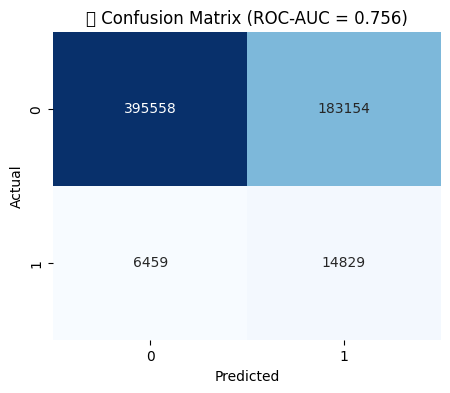

/kernel/lib/python3.10/site-packages/ml_kernel/_vendor/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/kernel/lib/python3.10/site-packages/ml_kernel/_vendor/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/kernel/lib/python3.10/site-packages/ml_kernel/_vendor/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


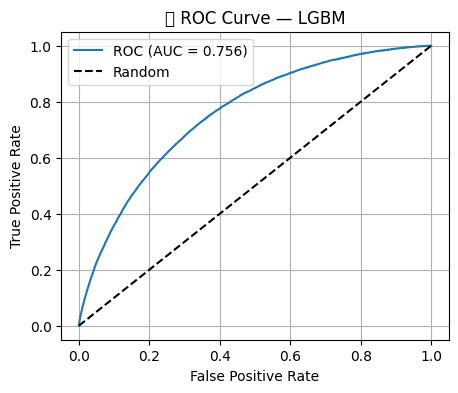

   id  pred     proba
0   0     0  0.273259
1   1     0  0.242932
2   2     1  0.785038
3   3     1  0.524850
4   4     1  0.593978


In [5]:
test_data = pd.read_parquet('/home/jupyter/project/processed_data_1/test/test.parquet')
preds = predict_model(test_data)
print(preds.head())

# ROC-AUC составил 0.7565. Recall достаточно хорош. Данная модель показала себя лучше всех